Notebook to determine confidence intervals around lagged correlations using bootstrapping.

In [1]:
import xarray as xr
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
def boostrap_correlations(x1, x2, num=100):
    """Returns boostrapped samples of size n, with replacement"""
    
    n = len(x1)
    indices = np.arange(0,n)
    mychoices1=np.random.choice(indices,size=num)
    mychoices2=np.random.choice(indices,size=num)
    x1_boots=x1[mychoices1]
    x2_boots=x2[mychoices2]
    r, p = scipy.stats.pearsonr(x1_boots,x2_boots )
    return r

In [3]:
lag_years = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1, 0,1,2,3,4,5,6,7,8,9,10]

In [4]:
def correlation_lagged( CIL, transport, lag_year,ax):
    if lag_year >0:
        x = CIL[0:-lag_year]
        y = transport[lag_year:]
    elif lag_year ==0:
        x = CIL
        y = transport
    else:
        x = CIL[-lag_year:]
        y = transport[:lag_year]
    r, p = scipy.stats.pearsonr(x,y )
    ax.scatter(x,y)
    ax.set_xlabel('CIL Area [km^2]')
    ax.set_ylabel('Shelf transport [m^3/s]')
    ax.set_title(f'Lag year {lag_year} and r= {r:0.3f}')
    return r

In [5]:
def boot_percentiles(CIL, transport, lag_year, num_reps=1000, upper=97.5,lower=2.5):
    if lag_year >0:
        x = CIL[0:-lag_year]
        y = transport[lag_year:]
    elif lag_year ==0:
        x = CIL
        y = transport
    else:
        x = CIL[-lag_year:]
        y = transport[:lag_year]
    boots_rs=[]

    for i in range(num_reps):
        boots_rs.append(boostrap_correlations(x,y, num=len(x)))
    lower_percentile = np.percentile(boots_rs,lower)
    upper_percentile = np.percentile(boots_rs,upper)
    return lower_percentile, upper_percentile

BeachyIsland
MakkovikBank
SealIsland
WhiteBay
Bonavista


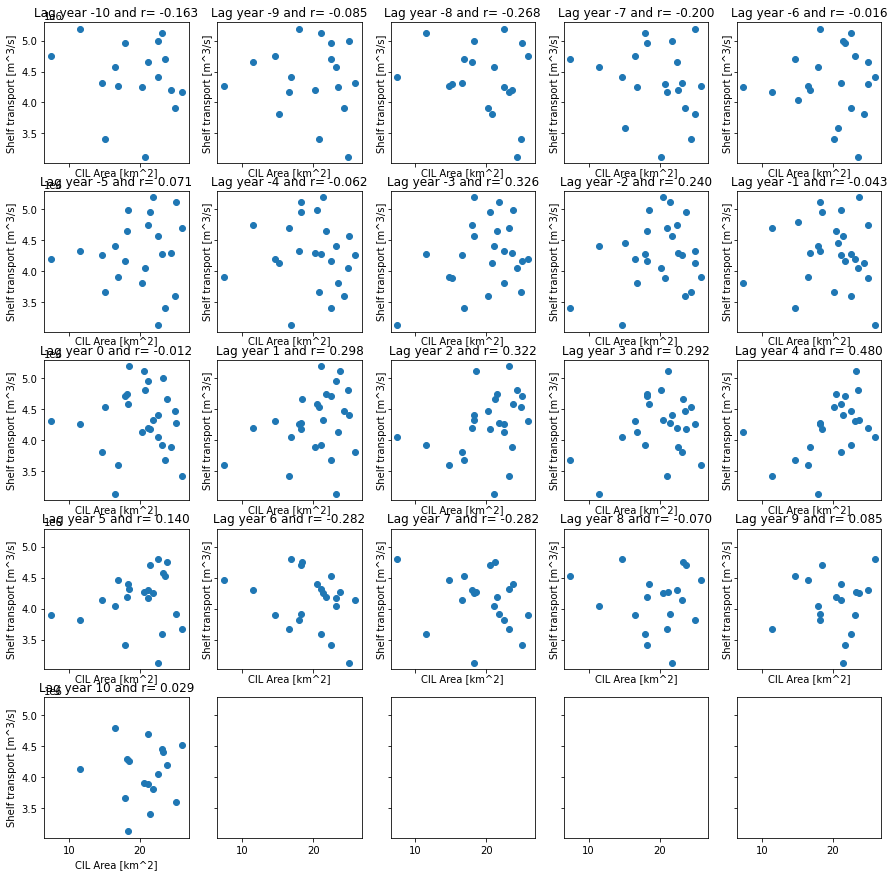

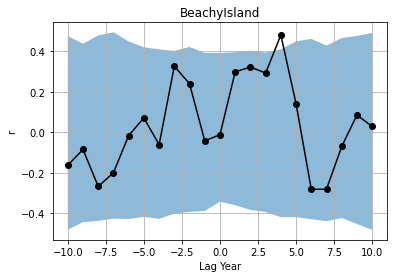

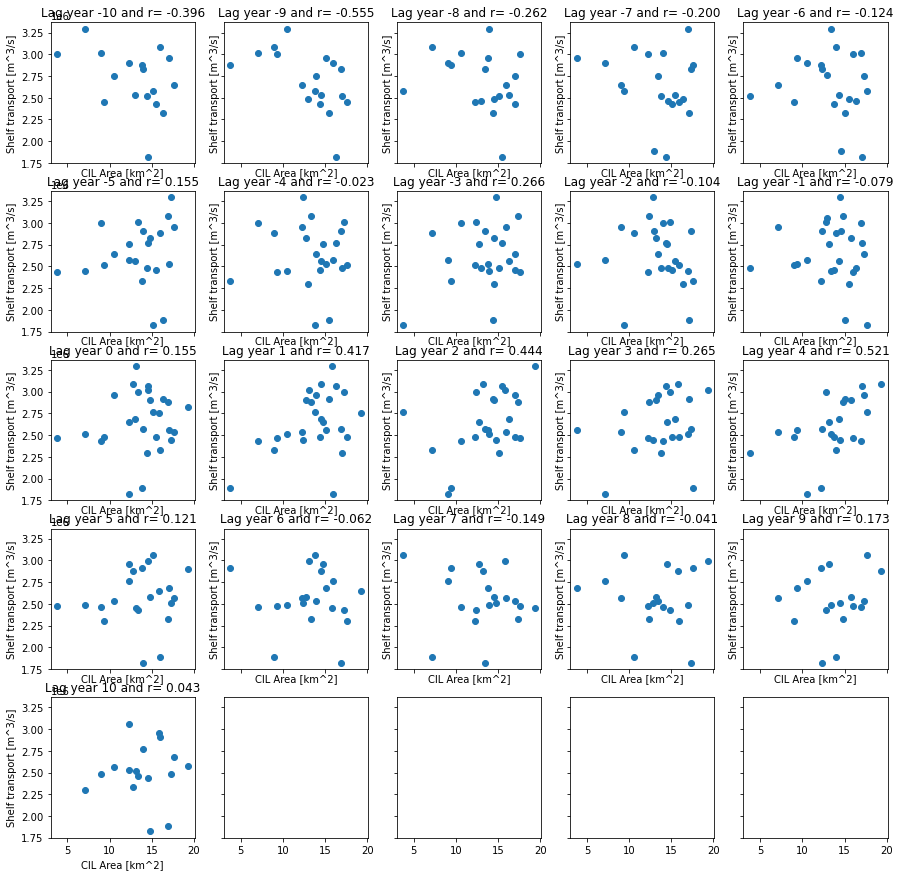

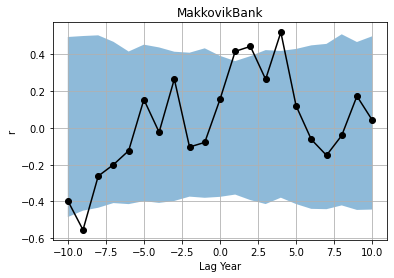

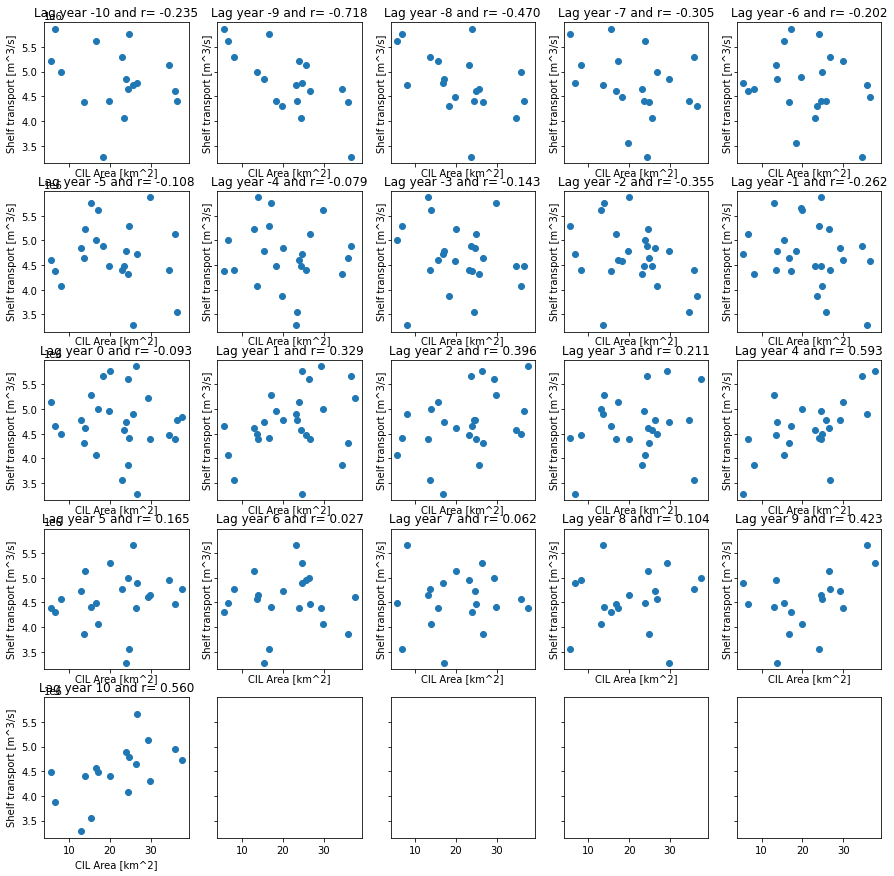

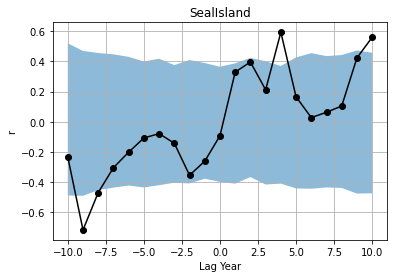

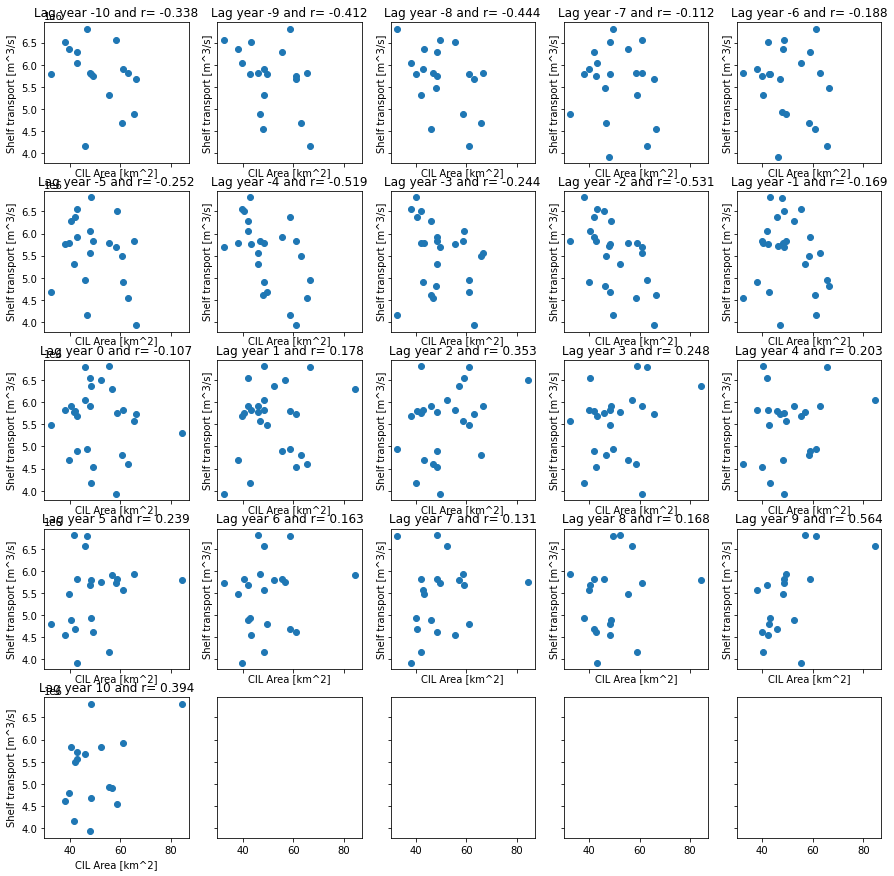

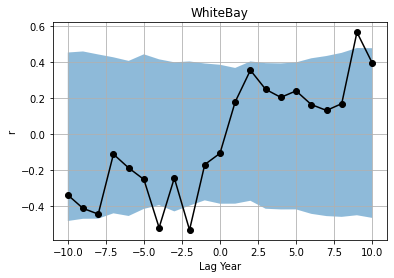

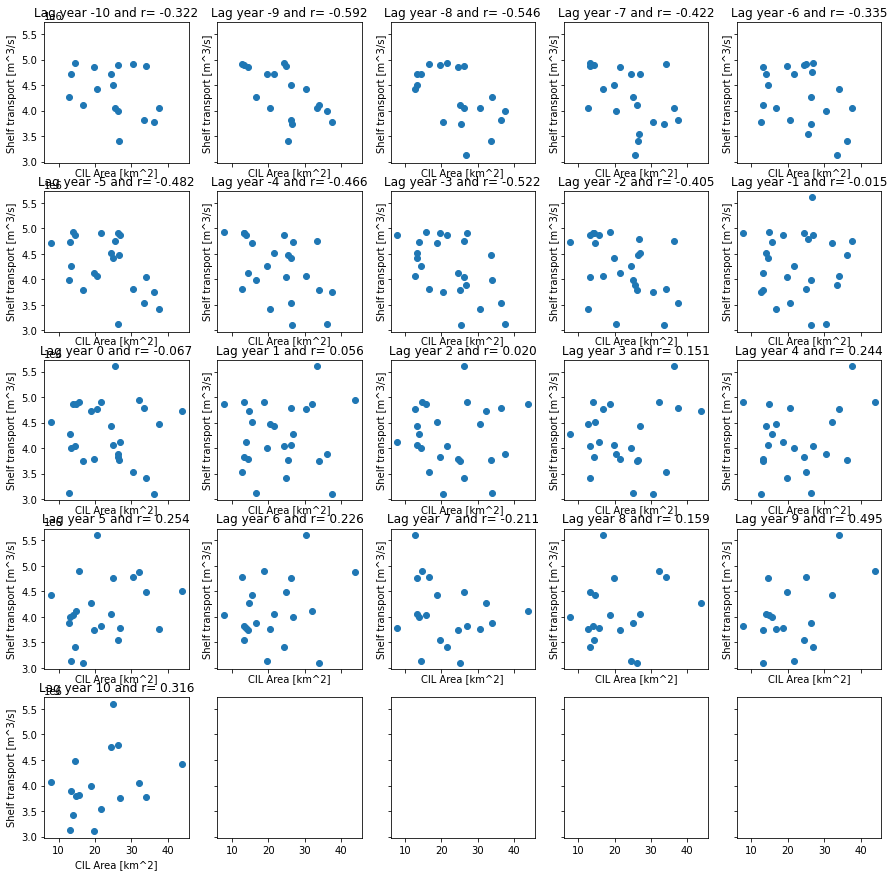

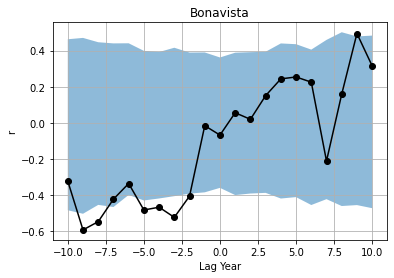

In [6]:
for name in ['BeachyIsland', 'MakkovikBank', 'SealIsland', 'WhiteBay', 'Bonavista']:
    print(name)
    d = xr.open_dataset(f'{name}.nc')
    CIL=d.CIL_Area.values
    transport=d.Shelf_Transport.values
    rs = []
    lowers=[]
    uppers=[]
    fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)
    for lag_year, ax in zip(lag_years, axs.flatten()):
        r = correlation_lagged(CIL, transport, lag_year, ax)
        rs.append(r)
        lower,upper =  boot_percentiles(CIL, transport,lag_year)
        lowers.append(lower)
        uppers.append(upper)
    fig, ax = plt.subplots()
    ax.plot(lag_years, rs, 'ko-')
    ax.fill_between(lag_years, lowers, uppers, alpha=0.5)
    ax.grid()
    ax.set_xlabel('Lag Year')
    ax.set_ylabel('r')
    ax.set_title(name)
    fig.savefig(f'{name}-laggedcorrelations.png')